<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных-(EDA)" data-toc-modified-id="Исследовательский-анализ-данных-(EDA)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ данных (EDA)</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов фитнес-центров

В данном проекте мы будем рассматривать и анализировать сеть фитнес-центров. Наша задача — провести анализ и подготовить план действий по удержанию клиентов. В нашем распоряжении есть информация о клиентах: пол, возраст, наличие контактного телефона, длительность текущего действующего абонемента, средняя частота посещений в неделю за предыдущий месяц и так далее. 

На основе данной информации нам и необходимо провести анализ: научиться прогнозировать вероятность оттока, сформировать типичные портреты клиентов, проанализировать основные признаки, наиболее сильно влияющие на отток и сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

## Изучение данных из файла

Первым делом импортируем необходимые библиотеки.

In [1]:
import pandas as pd # импорт библиотеки pandas
import seaborn as sns # импорт библиотеки seaborn
import matplotlib.pyplot as plt # импорт библиотеки matplotlib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

import warnings 
warnings.filterwarnings('ignore')

Далее загрузим и прочитаем фаил с данными:

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv') # чтение файла с данными и сохранение в df

In [3]:
df.head() # получение первых 5 строк таблицы df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Общая информация о датафрейме:**

In [4]:
df.info() # получение общей информации о данных в таблице df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Итак, в таблице четырнадцать столбцов. Тип данных в столбцах: `int64`, `float64`.

Согласно документации к данным:

* Gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах);
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
* Churn — факт оттока в текущем месяце.

**Вывод:**

На данном этапе мы импортировали необходимые библиотеки для анализа и получили информацию о наших данных, прочитали их, а также записали в переменную `df`. После вывода таблицы обнаружено, что названия столбцов написаны с большой буквы, исправим это в следующем шаге. Также мы узнали, что в таблице 14 столбцов, а типы данных в столбцах - это int64 и float64.

## Предобработка данных

**Названия столбцов**

Первым делом посмотрим на названия столбцов:

In [5]:
df.columns

Index(['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Contract_period', 'Group_visits', 'Age',
       'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime',
       'Avg_class_frequency_total', 'Avg_class_frequency_current_month',
       'Churn'],
      dtype='object')

Приведем названия к нижнему регистру:

In [6]:
df.columns = df.columns.str.lower() # приводим к нижнему регистру

In [7]:
df.columns # смотрим изменения

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Успех далее посмотрим на пропущенные значения в таблице.

**Пропущенные значения**

In [8]:
df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропущенные значения отсутствуют и это отлично.

**Типы данных**

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Заменим тип данных в столбце `month_to_end_contract` на int.

In [10]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype('int')

In [11]:
df['month_to_end_contract'].unique()

array([ 5, 12,  1,  6,  3, 10, 11,  9,  4,  7,  8,  2])

Успех, далее посмотрим дубликаты.

**Дубликаты**

In [12]:
df.duplicated().sum()

0

Дубликатов в наших данных нет, предобработку можно завершить.

**Вывод:**

В данном этапе мы занимались предобработкой данных, а именно изменили названия столбцов, поменяли тип данных, проверили наличие явных дубликатов и пропущенных значений. Пропущенные значения и дубликаты отсутствуют в нашем датафрейме.

## Исследовательский анализ данных (EDA)

In [13]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Ранее мы узнали, что отсутствующих признаков нет, значения после применения метода `describe` выглядят нормально, аномальных отклонений не наблюдается. 

*Типичный портрет клиента:*

* Возраст от 26 до 32 лет;
* Живет или работает в районе где расположен фитнес-центр;
* Занимается в фитнес-центре 1-2 раза в неделю;
* Сообщает свои контактные данные (телефон);
* В среднем потратил на прочие услуги центра около 150 Условных единиц.

Посмотрим на средние значения двух групп клиентов - тех кто ушел и тех кто остался, воспользуемся методом `groupby`.

In [14]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Исходя из таблицы можем сделать вывод, что пользователи которые ушли в отток реже посещали фитнес-центр средняя частота посещений в неделю на единицу меньше чем у тех, кто не ушел в отток, кроме того ушедшие клиенты чаще брали абонимент на короткий срок. 

Далее построим столбчатые гистограммы и распределения признаков для двух групп - тех, кто ушел в отток и тех, кто остался. Построим гистограммы с помощью цикла.

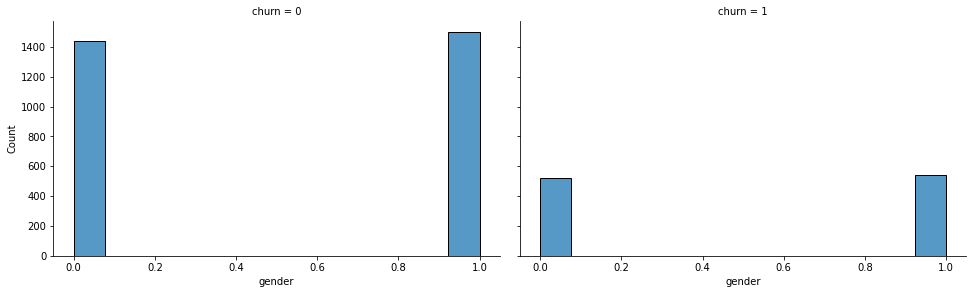

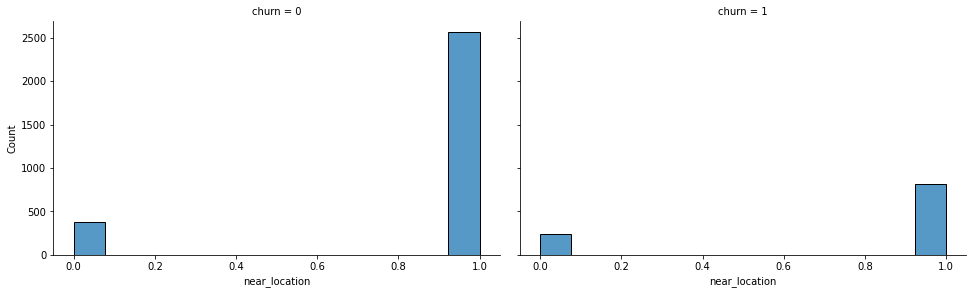

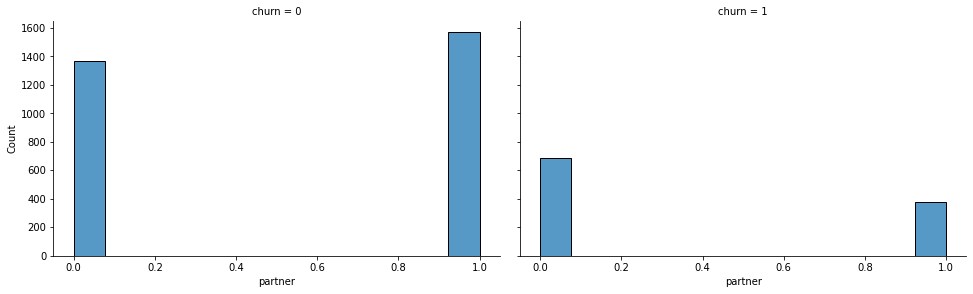

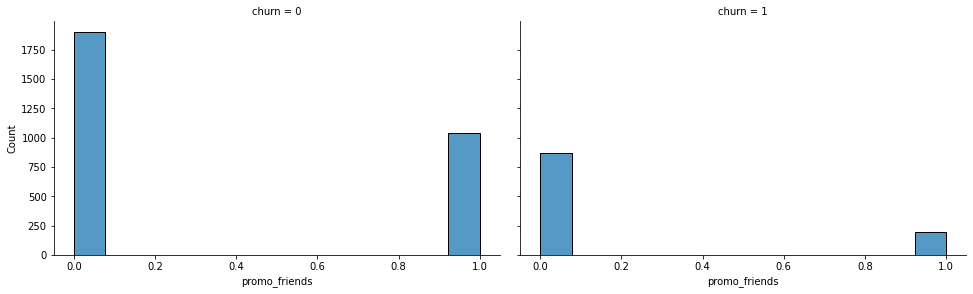

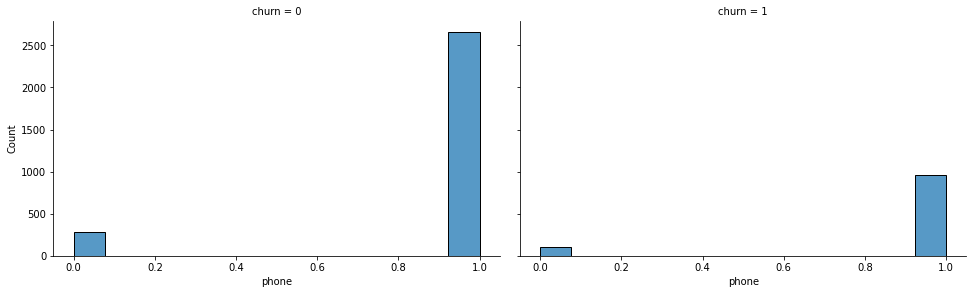

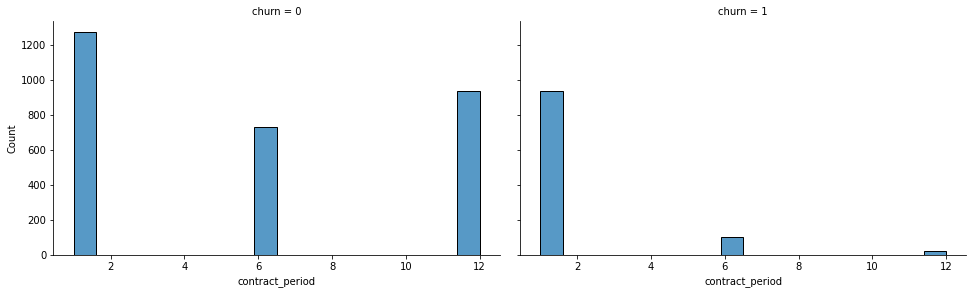

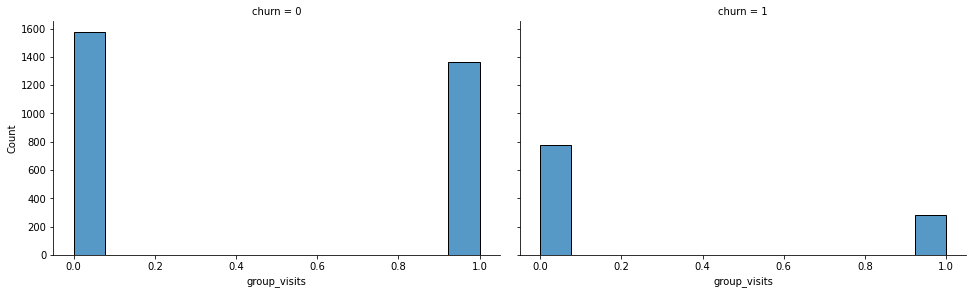

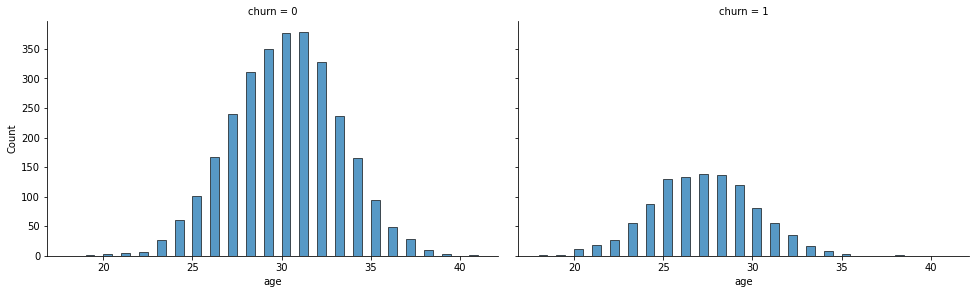

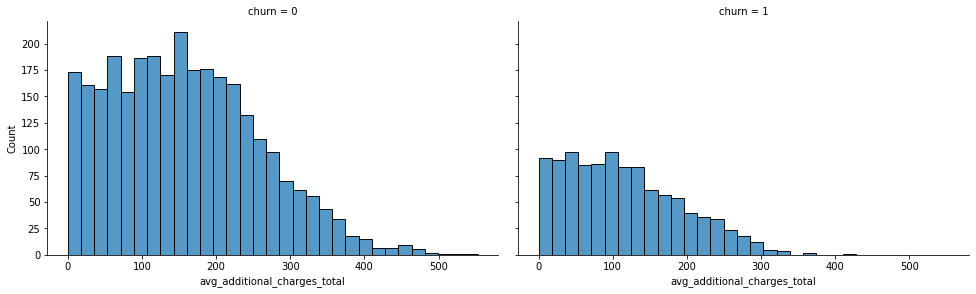

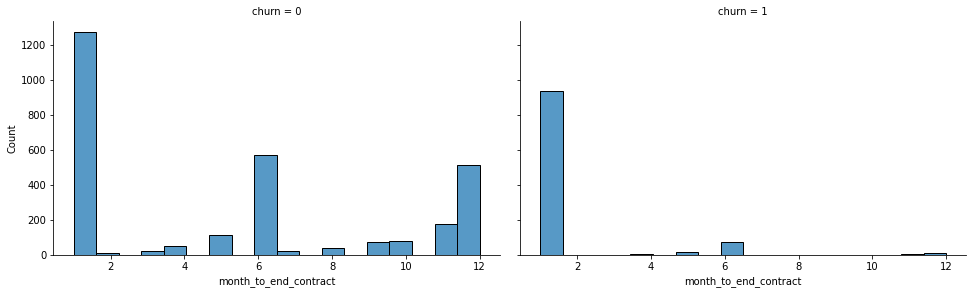

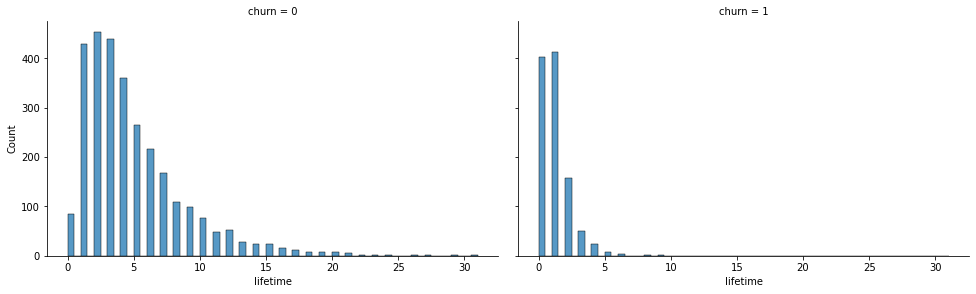

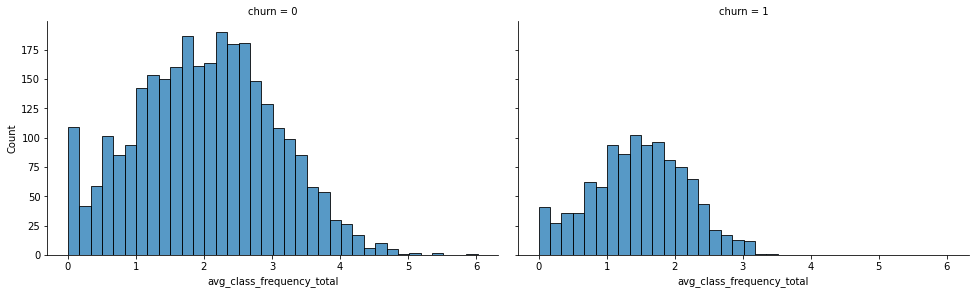

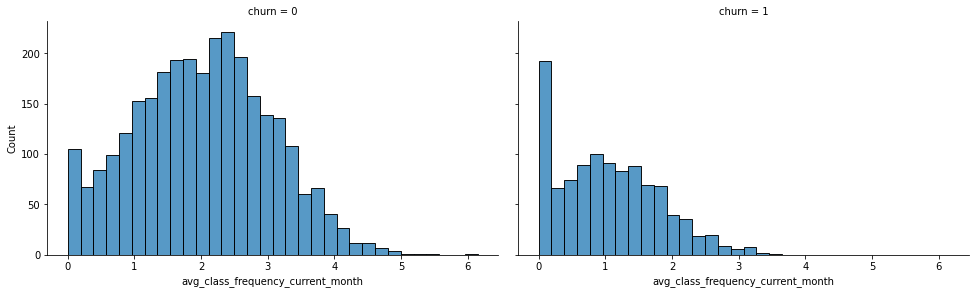

In [15]:
sign = df.drop(columns='churn')
df_plot = df.copy()

for i in sign.columns:
    g = sns.displot(data=df_plot, x=i, col='churn')
    g.fig.set_figwidth(14)
    g.fig.set_figheight(4)
    plt.show()

*Признаки клиентов которые ушли в отток:*

* Мужчины и женщины уходят примерно в одинаковом соотношении;
* Клиенты проживающие или работающие в районе, где находится фитнес-центр также уходят в отток;
* Клиенты которые не являются партнерами уходят чаще чем те кто является сотрудником компании-партнёра клуба, также чаще уходят клиенты которые не пользовались акцией «приведи друга»;
* Клиенты которые брали абонимент на месяц намного чаще уходили в отток, видимо это пользователи которые решили попробовать, но поняли, что такой досуг им не подходит;
* Клиенты, которые не посещали групповые тренировки часще уходили, чем остальные;
* В основном в отток попали клиенты в возрасте от 25 до 29 лет;
* Траты на услуги клиентов оттока в основном распределены от 0 до 150 усл.ед.;
* У большинства клиентов срок действия абонимента 1 месяц;
* Клиенты ушедшие в отток в среднем в неделю не посещали тренировки, но были редкие моменты когда тренировки доходили до 3 раз в неделю; 

**Построим матрицу корреляций:**

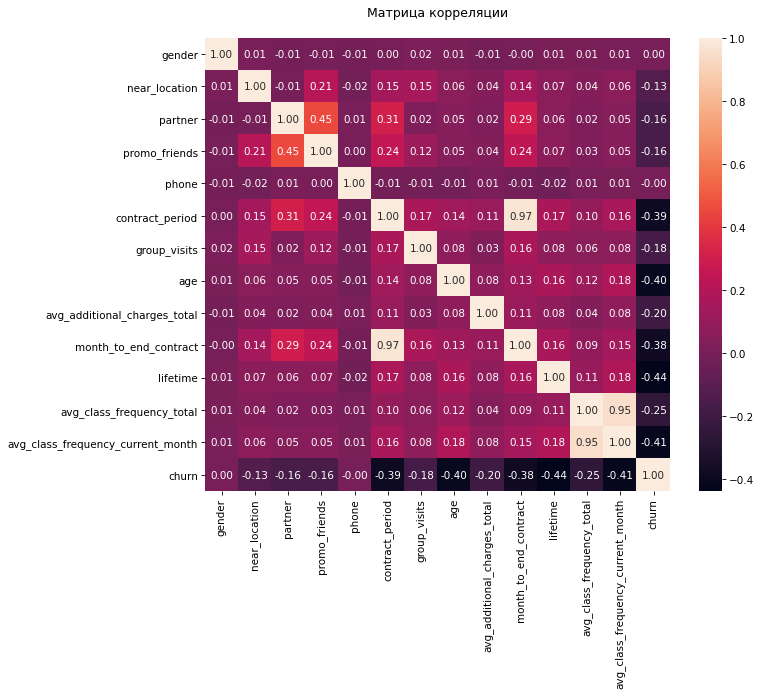

In [16]:
cm = df.corr() #вычисляем матрицу корреляций

plt.figure(figsize=(10,8), dpi=75)
sns.heatmap(cm, annot=True, fmt='.2f') #нарисуем тепловую карту с подписями для матрицы корреляций

plt.title('Матрица корреляции'+'\n')
plt.show()

Наблюдаем сильную корреляцию между признаками:

* Cрока до окончания текущего действующего абонемента и длительности текущего действующего абонемента - показатель составил 0.97;
* Средней частоты посещений в неделю за предыдущий месяц и средней частоты посещений в неделю за все время с начала действия абонемента - показатель составил 0.95; 

Данные признаки отражают почти одинаковые данные, поэтому их показатель корреляции такой высокий, для более эффективной работы с ML мы удалим один из этих признаков в каждой из пар.

**Вывод:**

В данном этапе мы проводили исследовательский анализ данных, а точнее рассмотрели показатели наших признаков на наличие аномалий, посмотрели средние значения признаков активных пользователей и тех кто ушел в отток, а также построили гистограммы признаков пользовтаелей фитнес-центров и построили матрицу корреляции, после каждого шага данного этапа были сделаны выводы. 

## Построение модели прогнозирования оттока клиентов

В этом этапе мы построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Первым делом удалим те признаки, которые сильно коррелируют друг с другом, а далее поделим данные на обучающую и валидационную выборку.

In [17]:
df_new = df.copy()
df_new = df_new.drop(['month_to_end_contract','avg_class_frequency_total'], axis=1)

Готово, теперь разобъем данные на обучающую и валидационную выборку функцией `train_test_split`.

In [18]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df_new.drop('churn', axis=1) 
y = df_new['churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Готово, теперь обучим модель на train-выборке двумя способами: `логистической регрессией` и `случайным лесом`.

**Логистическая регрессиия**

In [19]:
# зададим алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear', random_state=0)  

# обучим модель
lr_model.fit(X_train, y_train)

lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:, 1]

**Случайный лес**

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

Далее оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 

**Оценка метрик**

Сначала проведем оценку accuracy, precision и recall модели логистической регрессии.

In [21]:
# выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, lr_predictions)))

Accuracy: 0.91
Precision: 0.85
Recall: 0.82


Показатель Accuracy - доля верно угаданных ответов из всех прогнозов составил 91%, что является весьма хорошим результатом. Показатели точности также являются высокими Precision - 85% и Recall - 82%.


Проведем оценку метрик для модели случайного леса.

In [22]:
# выведем метрики для полученного прогноза
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score (y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score (y_test, rf_predictions)))

Accuracy: 0.90
Precision: 0.85
Recall: 0.77


Показатель Accuracy составил 90%, что на 1% меньше чем у модели логистической регрессии. Показатель точности также показали меньший результат Recall - 80%.

Исходя из показателей метрик по двум моделям вперед выходит модель логистической регрессии, точность и предсказания данной модели чуть лучше чем у модели случайного леса.

**Вывод:**

В данном шаге мы строили модели прогнозировнаия оттока клиентов с помощью логистической регрессии и случайного леса. Модель логистической регрессии показала себя лучше: Показатели Accuracy и Recall оказались выше чем у модели случайного леса.

## Кластеризация клиентов

Первым делом стандартизируем данные.

In [23]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Строим матрицу расстояний с помощью функции `linkage()` на стандартизованной матрице признаков и нарисуем дендрограмму. 

In [24]:
linked = linkage(X_sc, method = 'ward') 

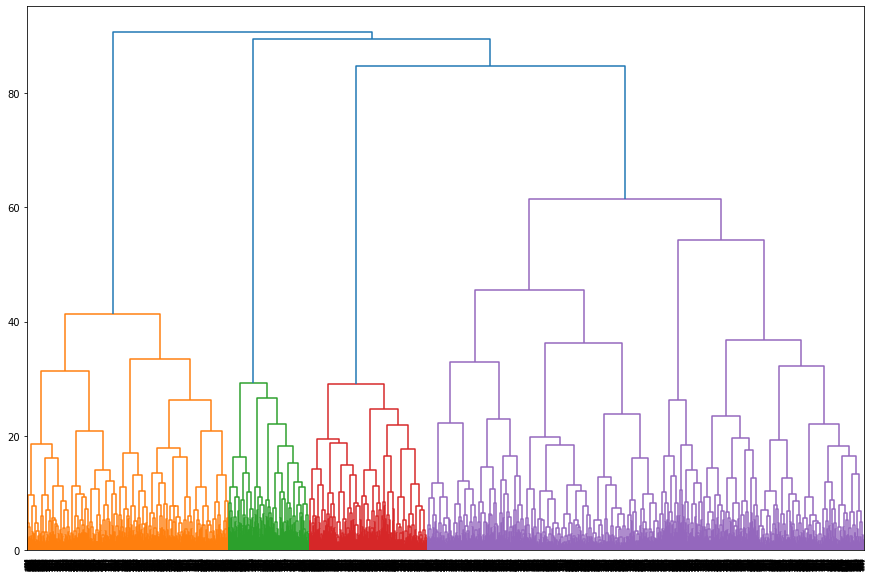

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

По дендрограмме видно 4 кластера, но фиолетовый кластер огромен, поэтому будем принимать число кластеров равное пяти. 

**Cпрогнозируем кластеры клиентов**

Для этого обучим модель кластеризации на основании алгоритма `K-Means`.

In [26]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(X_sc)

In [27]:
df_new['cluster_km'] = labels

Готово, теперь выведем средние значения признаков для кластеров, для этого воспользуемся методом `groupby()`.

In [28]:
# выводим статистику по средним значениям признаков по кластеру
clusters = df_new.drop('churn', axis=1).groupby(['cluster_km']).mean().round(2).T
clusters

cluster_km,0,1,2,3,4
gender,0.50,0.50,0.50,0.53,0.52
near_location,1.00,0.00,1.00,1.00,0.86
partner,0.89,0.49,0.22,0.38,0.47
promo_friends,1.00,0.08,0.07,0.01,0.31
phone,1.00,1.00,1.00,1.00,0.00
contract_period,6.92,2.99,2.01,6.21,4.78
group_visits,0.52,0.23,0.28,0.54,0.43
age,29.61,28.68,27.58,30.70,29.30
avg_additional_charges_total,153.42,137.13,119.34,176.26,144.21
lifetime,4.28,2.97,1.92,5.42,3.94


Отметим характерные отличия кластеров:

* Кластер 0 - все клиенты использовали промо-код «приведи друга», а также большинство клиентов являются сотрудниками компании-партнёра клуба;
* Кластер 1 - клиенты которые реже остальных ходят на групповые занятия, а также живут не в районе где находится фитнес-центр;
* Кластер 2 - самая неактивная группа клиентов, все признаки на низком уровне скорее всего, эта группа с самым высоким показателем оттока;
* Кластер 3 - самая возрастная группа, которая еще и тратит больше остальных, отметим что клиенты группы уже давно посещают фитнес-центр и делают это достаточно активно;
* Кластер 4 - середнячки, но с особенностью, номер телефона данная группа клиентов не оставляет.


**Распределение признаков кластеров**

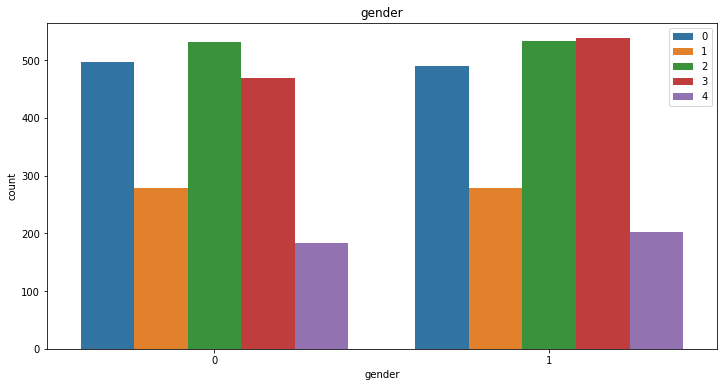

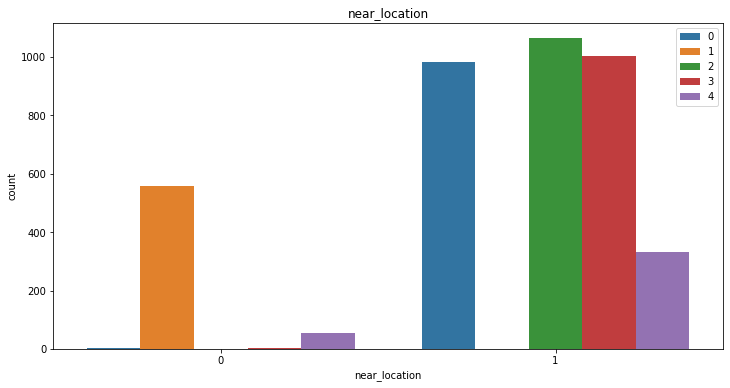

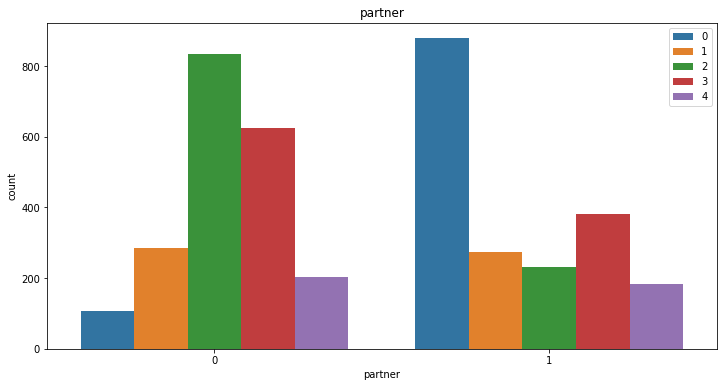

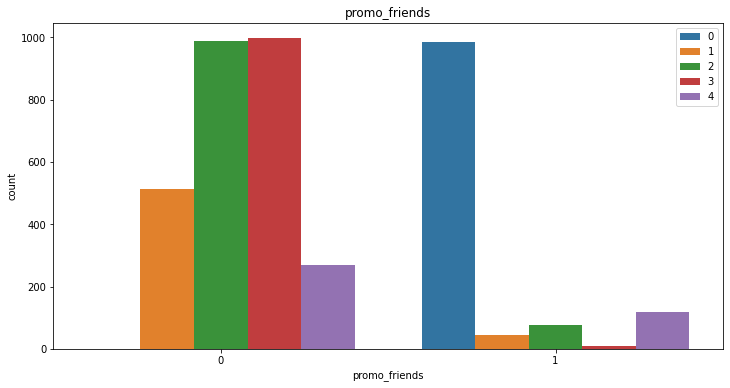

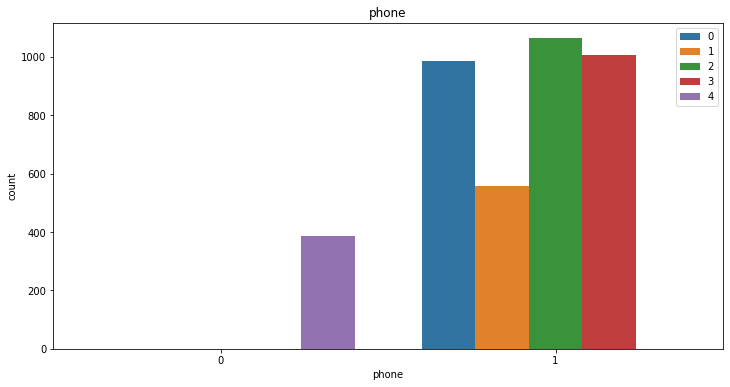

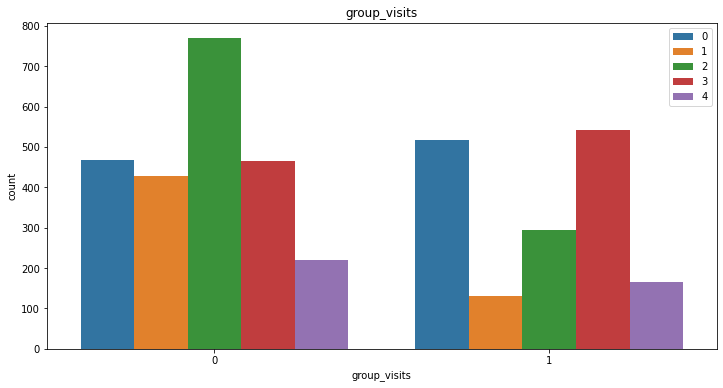

In [29]:
for i in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']:
    plt.figure(figsize=(12,6))
    sns.countplot(x=df_new[i], hue='cluster_km', data=df_new)
    plt.title(i)
    plt.legend(loc='upper right')
    plt.show()

Исходя из распределения можнм отметить:

* Распределение по полу в каждом кластере равномерно;
* Признак районности показывает, что клиенты первого кластера живут или работают отдаленно от района, остальные группы расположенны в этом же районе;
* По акции приведи друга прошли все клиенты нулевого кластера, в остальных кластерах акция почти используется.
* Номер телефона оставили почти все клиенты кластеров, отличился только четвертый кластер, клиенты этого кластера не оставляли номер телефона.
* В первом и втором кластере пользователи предпочитают заниматься не в группах.

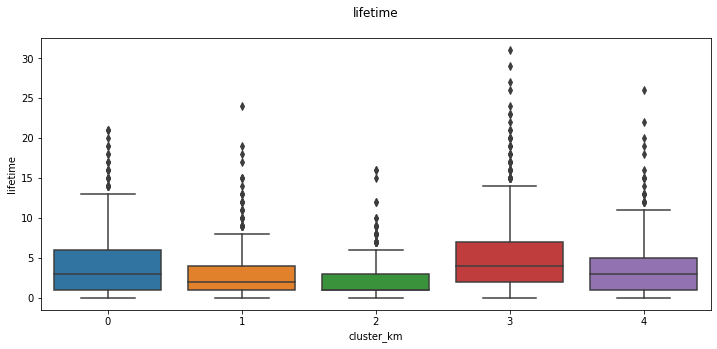

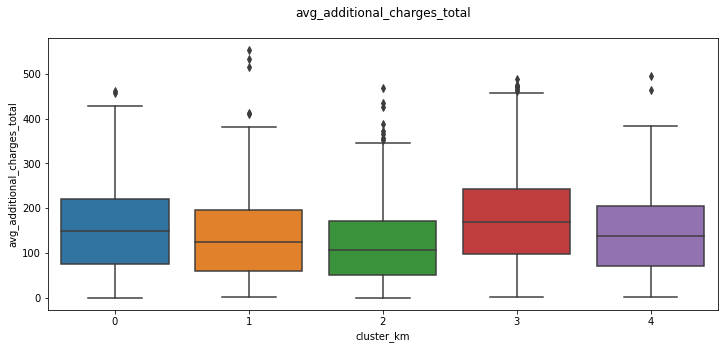

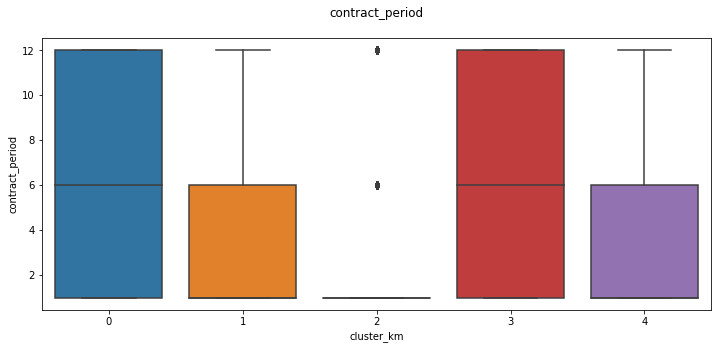

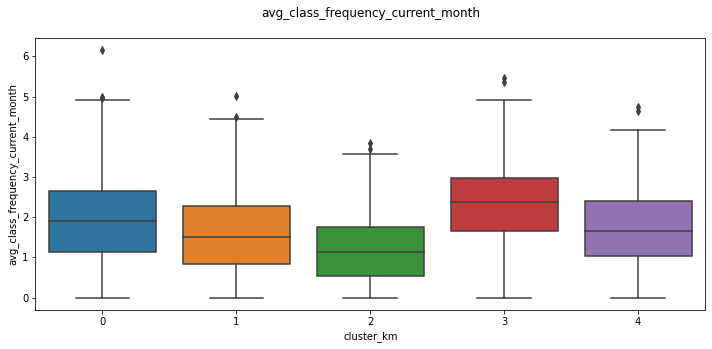

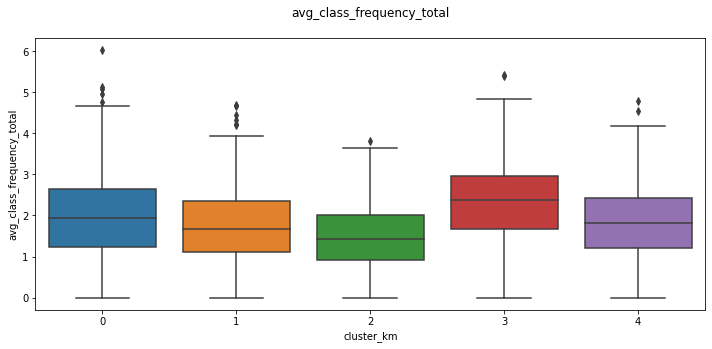

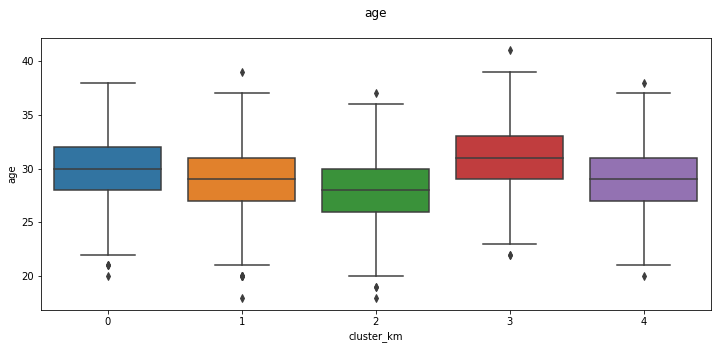

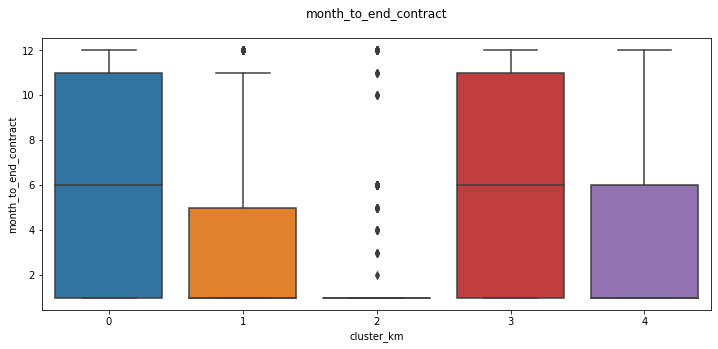

In [30]:
for i in ['lifetime', 'avg_additional_charges_total', 'contract_period', 'avg_class_frequency_current_month', 'avg_class_frequency_total', 'age', 'month_to_end_contract']:
    plt.figure(figsize=(12, 5))
    sns.boxplot(x='cluster_km', y=df[i], data=df_new)
    plt.title(i+'\n')
    plt.show()

Исходя из данных графиков можем отметить, что на фоне всех кластеров по практически всем признакам третий кластер показал себя лучше всего, чего не скажешь о первом и втором кластерах, их показатели достаточно "Не живые" можнм предположить, что клиенты этих кластеров чаще уходят в отток.

**Доля оттока по кластерам**

In [31]:
quit = df_new.groupby('cluster_km')['churn'].mean().round(3).sort_values()
quit

cluster_km
3    0.015
0    0.120
4    0.267
1    0.403
2    0.564
Name: churn, dtype: float64

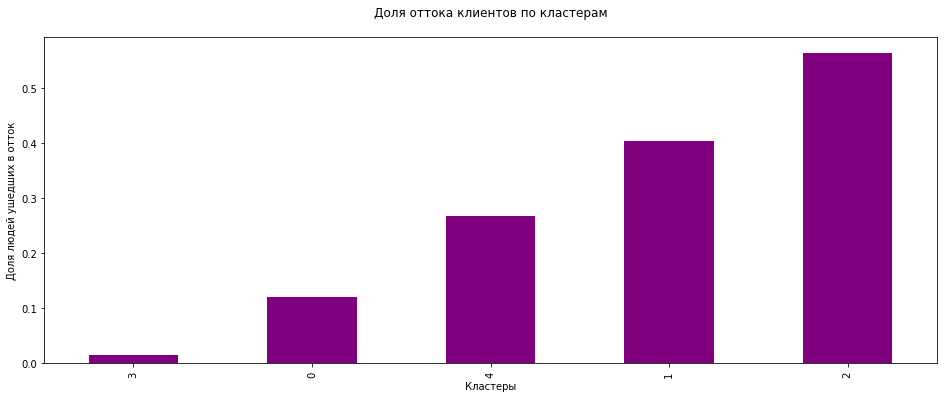

In [32]:
quit.plot(kind='bar', figsize = (16,6), color='purple')
plt.xlabel('Кластеры')
plt.ylabel('Доля людей ушедших в отток')
plt.title('Доля оттока клиентов по кластерам'+'\n')
plt.show()

Самым надежным кластером является третий кластер, почти все клиенты являются акивными, чего не скажешь про первый и второй кластер. Отток клиентов у второго кластера превышает 50%, первый кластер также показал высокий показатель оттока около 40%.

**Вывод:**

В данном шаге мы занимались кластеризацией клиентов. В процессе кластеризации нам удалось выделить 5 кластеров и их отличительные признаки:

* Кластер 0 - все клиенты использовали промо-код «приведи друга», а также большинство клиентов являются сотрудниками компании-партнёра клуба;
* Кластер 1 - клиенты которые реже остальных ходят на групповые занятия, а также живут не в районе где находится фитнес-центр;
* Кластер 2 - самая неактивная группа клиентов, все признаки на низком уровне скорее всего, эта группа с самым высоким показателем оттока;
* Кластер 3 - самая возрастная группа, которая еще и тратит больше остальных, отметим что клиенты группы уже давно посещают фитнес-центр и делают это достаточно активно;
* Кластер 4 - середнячки, но с особенностью, номер телефона данная группа клиентов не оставляет.

После того как мы рассмотрели распределения признаков каждого из кластеров мы предположили, что первый и второй кластеры имеют высокий показатель оттока, и по итогам расчета так и оказалось. Около 56% клиентов второго кластера ушли в отток и 40% клиентов первого кластера также ушли в отток. Также отметим третий кластер почти все клиенты остались клиентами фитнес-центров.

## Итоговый вывод

В данном проекте мы исследовали, анализировали деятельность фитнес-центров. Задача проекта заключалась в том чтобы сделать план по удержанию клиентов. Для работы был представлен датасет из 4 000 записей.

Первым делом мы изучили наши данные, датасет состоял из четырнадцати столбцов в которых содержалась информация о активности клиентов. Тип данных в столбцах: `int64`, `float64`.

Далее для нашего удобства мы занимались предобработкой данных, а именно изменили названия столбцов, поменяли тип данных, проверили наличие явных дубликатов и пропущенных значений. Пропущенные значения и дубликаты отсутствуют в нашем датафрейме.

После обработки мы занялись исследованием данных, посмотрели кто ушел в отток и кто остался в центре, первым выводом после группировки по столбцу `churn` был таким: пользователи которые ушли в отток реже посещали фитнес-центр средняя частота посещений в неделю на единицу меньше чем у тех, кто не ушел в отток, кроме того ушедшие клиенты чаще брали абонимент на короткий срок.

При построении гистограмм и анализе результатов мы сделали такие выводы:

* Мужчины и женщины уходят примерно в одинаковом соотношении;
* Клиенты проживающие или работающие в районе, где находится фитнес-центр также уходят в отток;
* Клиенты которые не являются партнерами уходят чаще чем те кто является сотрудником компании-партнёра клуба, также чаще уходят клиенты которые не пользовались акцией «приведи друга»;
* Клиенты которые брали абонимент на месяц намного чаще уходили в отток, видимо это пользователи которые решили попробовать, но поняли, что такой досуг им не подходит;
* Клиенты, которые не посещали групповые тренировки часще уходили, чем остальные;
* В основном в отток попали клиенты в возрасте от 25 до 29 лет;
* Траты на услуги клиентов оттока в основном распределены от 0 до 150 усл.ед.;
* У большинства клиентов срок действия абонимента 1 месяц;
* Клиенты ушедшие в отток в среднем в неделю не посещали тренировки, но были редкие моменты когда тренировки доходили до 3 раз в неделю. 

Далее мы провели кластеризацию клиентов и выделили 5 кластеров клиентов и посмотрели средние значения признаков кластеров. И отметили характерные отличия кластеров:

* Кластер 0 - все клиенты использовали промо-код «приведи друга», а также большинство клиентов являются сотрудниками компании-партнёра клуба;
* Кластер 1 - клиенты которые реже остальных ходят на групповые занятия, а также живут не в районе где находится фитнес-центр;
* Кластер 2 - самая неактивная группа клиентов, все признаки на низком уровне скорее всего, эта группа с самым высоким показателем оттока;
* Кластер 3 - самая возрастная группа, которая еще и тратит больше остальных, отметим что клиенты группы уже давно посещают фитнес-центр и делают это достаточно активно;
* Кластер 4 - середнячки, но с особенностью, номер телефона данная группа клиентов не оставляет.

По итогам построения гистограм мы сделали подобные выводы и предположили что первый и второй кластеры чаще уходят в отток. Сгруппировав данные мы убедились в этом около 56% клиентов второго кластера ушли в отток и 40% клиентов первого кластера также ушли в отток. Третий кластер отметился тем что почти все клиенты остались клиентами фитнес-центров - это самый лояльный кластер.

**Рекомендации для удержания клиентов фитнес центров:**

* Изначально определять портрет клиентов, и относить их в определенную группу. После этого для каждой группы клиентов предоставлять уникальные условия/акции, чтобы закрыть потребности групп и снизить отток клиентов;
* Расширить групповые занятия, например добавить новые виды спорта и дополнительно стимулировать клиентов на посещение групповых занятий, думаю так повысится социализация между клиентами и они будут реже попадать в отток, тем более исходя из наших данных мы видим подобную зависимость. 
* Продвигать продажи долгосрочных абониментов, клиенты с долгосрочными абониментами уходят в отток намного реже.